### Fake PII data: Exploratory data analysis

This notebook is used to verify the different fake entities before and after the creation of a synthetic dataset / augmented dataset. First part looks at the generation details and stats, second part evaluates the created synthetic dataset after it has been generated.

In [1]:
import pandas as pd

from presidio_evaluator.data_generator.extensions import generate_iban, generate_ip_addresses, generate_SSNs, \
    generate_company_names, generate_url, generate_roles, generate_titles, generate_nationality, generate_nation_man, \
    generate_nation_woman, generate_nation_plural, generate_title

from presidio_evaluator.data_generator import FakeDataGenerator, read_synth_dataset

from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
synth_dataset = "../data/conll_size_10000_date_November_29_2020.json"

1. Evaluate generation logic and the fake PII bank used during generation

In [2]:
df = pd.read_csv("../presidio_evaluator/data_generator/raw_data/FakeNameGenerator.com_3000.csv",encoding="utf-8")

In [3]:
df.head(3)

,Number,Gender,NameSet,Title,GivenName,MiddleInitial,Surname,StreetAddress,City,State,...,Vehicle,Domain,BloodType,Pounds,Kilograms,FeetInches,Centimeters,GUID,Latitude,Longitude
0,1,female,Czech,Mrs.,Marie,J,Hamanová,P.O. Box 255,Kangerlussuaq,QE,...,1995 Zastava 65,MarathonDancing.gl,O+,217.6,98.9,"5' 5""",164,6781b04d-7b5f-4c1a-bceb-b953e6ef70d7,77.377518,-67.015569
1,2,female,French,Ms.,Patricia,G,Desrosiers,Avenida Noruega 42,Vila Real,VR,...,2006 Lexus GS,LostMillions.com.pt,O+,118.1,53.7,"5' 0""",152,2b2e7e1a-855f-4089-a570-c0af2381a6d6,41.274541,-7.876658
2,3,female,American,Ms.,Debra,O,Neal,1659 Hoog St,Brakpan,GA,...,1993 Honda Prelude,MediumTube.co.za,A+,120.1,54.6,"5' 4""",162,2ef83f4c-3102-4f79-839d-c75bf6a06f0a,-26.220960,28.283398


In [4]:
generator = FakeDataGenerator(fake_pii_df=df, 
                              templates=None, 
                              dictionary_path=None,
                              ignore_types=None)

In [5]:
pii_df = generator.prep_fake_pii(df)

Preparing fake PII data for ingestion
Generating address parts
Generating roles
Generating titles
Generating nationalities
Generating IBANs
Generating IP addresses
Generating SSN numbers
Generating URLs
Generating company names
Finished preparing fake PII data


In [6]:
for (name, series) in pii_df.iteritems():
    print(name)
    print("Unique values: {}".format(len(series.unique())))
    print(series.value_counts())
    print("\n**************\n")

Number
Unique values: 3000
2047    1
1042    1
1060    1
1058    1
1056    1
       ..
2546    1
497     1
2544    1
495     1
2049    1
Name: Number, Length: 3000, dtype: int64

**************

GENDER
Unique values: 2
male      1603
female    1397
Name: GENDER, dtype: int64

**************

NameSet
Unique values: 24
Russian                  156
Danish                   143
England/Wales            141
Czech                    140
German                   139
Hispanic                 133
Swedish                  133
Hungarian                132
Chechen (Latin)          131
French                   130
Japanese (Anglicized)    128
Italian                  128
American                 127
Croatian                 123
Slovenian                123
Finnish                  122
Brazil                   114
Greenland                114
Dutch                    113
Polish                   108
Norwegian                108
Icelandic                107
Australian               106
Scottish      

In [7]:
from wordcloud import WordCloud

def series_to_wordcloud(series):
    freqs = series.value_counts()
    wordcloud = WordCloud(background_color='white',width=800,height=400).generate_from_frequencies(freqs)
    fig = plt.figure(figsize=(16, 8))
    plt.suptitle("{} word cloud".format(series.name))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

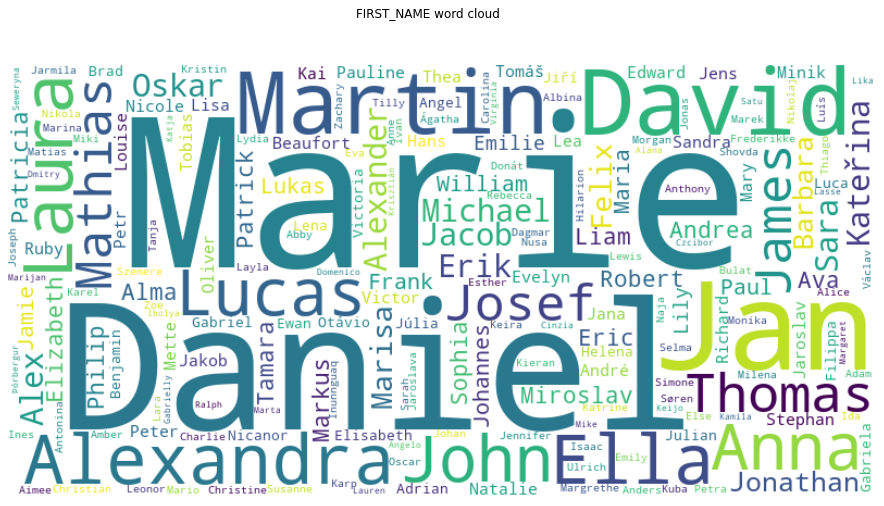

In [8]:
series_to_wordcloud(pii_df.FIRST_NAME)

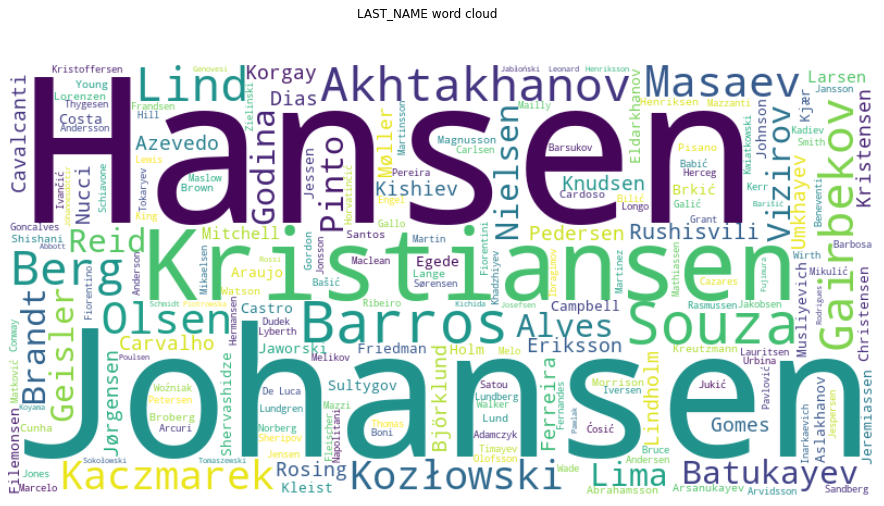

In [9]:
series_to_wordcloud(pii_df.LAST_NAME)

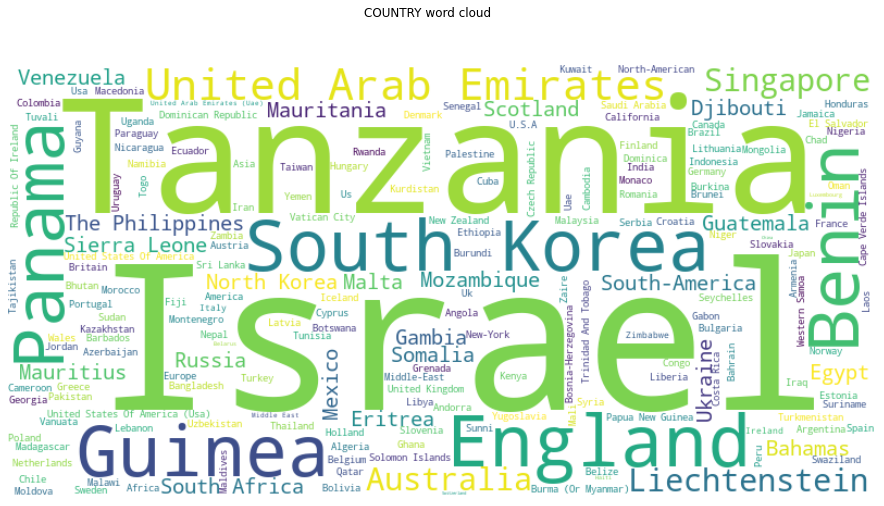

In [10]:
series_to_wordcloud(pii_df.COUNTRY)

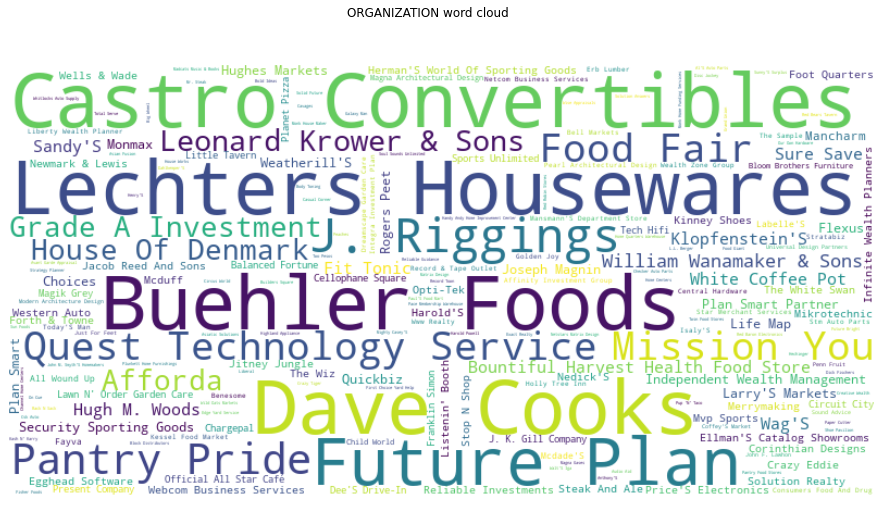

In [11]:
series_to_wordcloud(pii_df.ORGANIZATION)

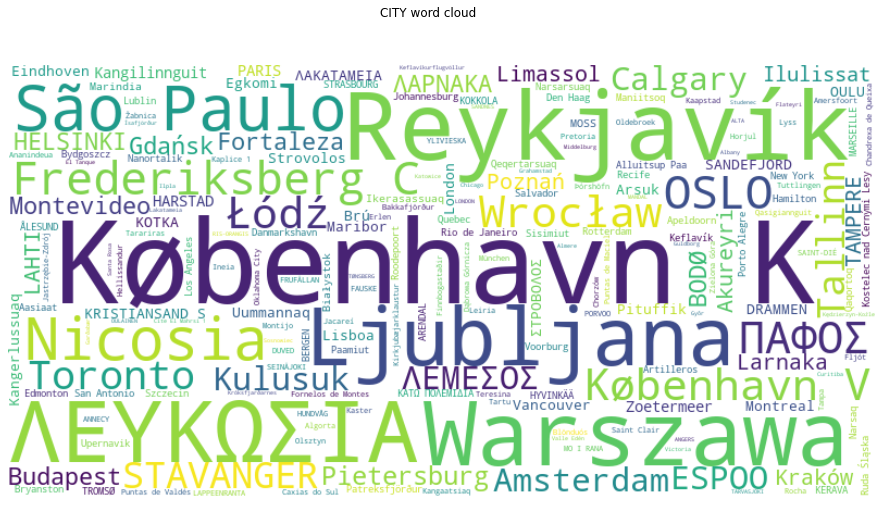

In [12]:
series_to_wordcloud(pii_df.CITY)

2. Evaluate different entities in the synthetic dataset after creation

In [14]:
synth = read_synth_dataset(synth_dataset)

In [15]:
sentences_only = [(sample.full_text,sample.metadata) for sample in synth]

In [16]:
sentences_only[2]

('Profitpros sets terms on 7-year straight.',
 {'Gender': 'male',
  'NameSet': 'Danish',
  'Country': 'Morocco',
  'Lowercase': False,
  'Template#': 6122})

In [17]:
print("Proportions of female vs. male based samples:")
Counter([sentence[1]['Gender'] for sentence in sentences_only])

Proportions of female vs. male based samples:


Counter({'female': 4719, 'male': 5281})

In [18]:
print("Proportion of lower case samples:")
Counter([sentence[1]['Lowercase'] for sentence in sentences_only])

Proportion of lower case samples:


Counter({False: 8867, True: 1133})

In [19]:
print("Proportion of nameset across samples:")
Counter([sentence[1]['NameSet'] for sentence in sentences_only])

Proportion of nameset across samples:


Counter({'England/Wales': 476,
         'Dutch': 353,
         'Danish': 472,
         'Russian': 522,
         'Hungarian': 409,
         'Polish': 364,
         'Greenland': 392,
         'Finnish': 413,
         'Chechen (Latin)': 458,
         'Australian': 384,
         'Croatian': 382,
         'Norwegian': 379,
         'American': 413,
         'Scottish': 338,
         'Czech': 463,
         'French': 430,
         'Swedish': 415,
         'German': 467,
         'Slovenian': 399,
         'Icelandic': 347,
         'Brazil': 378,
         'Hispanic': 439,
         'Japanese (Anglicized)': 444,
         'Italian': 463})

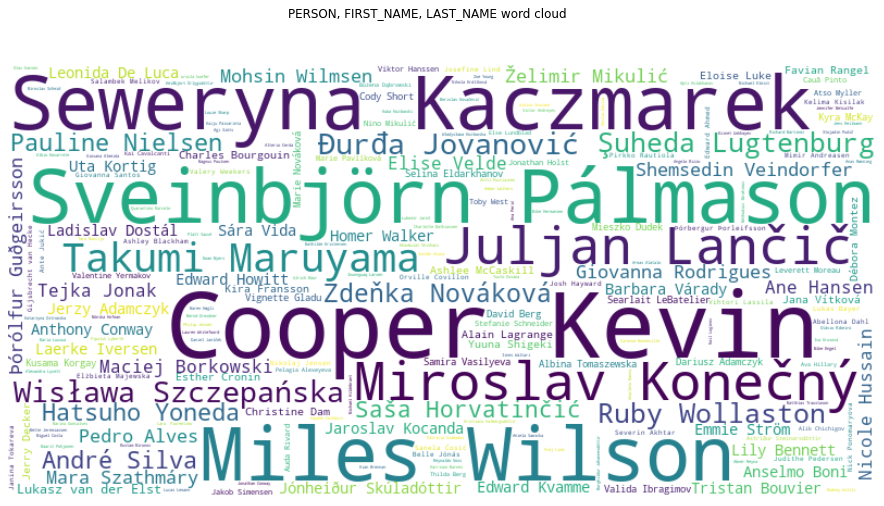

In [20]:
def get_entity_values_from_sample(sample,entity_types):
    name_entities = [span.entity_value for span in sample.spans if span.entity_type in entity_types]
    return name_entities
    
names = [get_entity_values_from_sample(sample,['PERSON','FIRST_NAME','LAST_NAME']) for sample in synth]
names = [item for sublist in names for item in sublist]
series_to_wordcloud(pd.Series(names,name='PERSON, FIRST_NAME, LAST_NAME'))

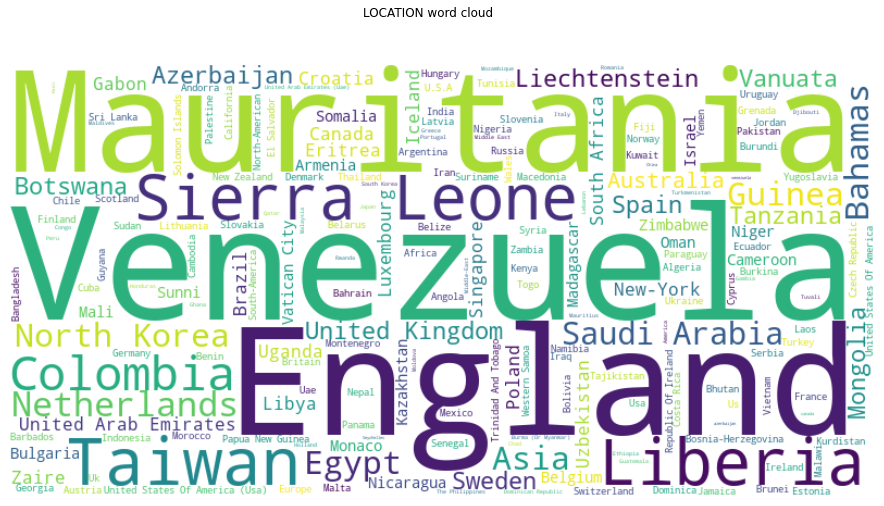

In [21]:
countries = [get_entity_values_from_sample(sample,['LOCATION']) for sample in synth]
countries = [item for sublist in countries for item in sublist]
series_to_wordcloud(pd.Series(countries,name='LOCATION'))

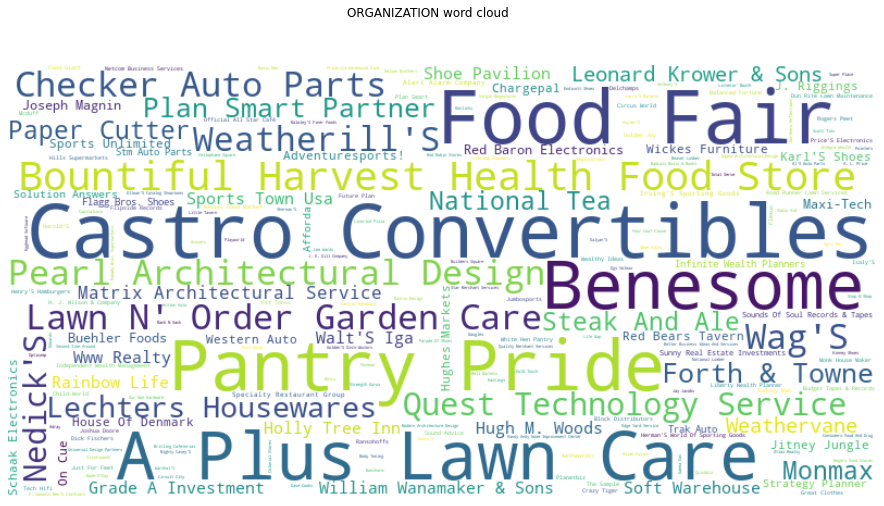

In [22]:
orgs = [get_entity_values_from_sample(sample,['ORGANIZATION']) for sample in synth]
orgs = [item for sublist in orgs for item in sublist]
series_to_wordcloud(pd.Series(orgs,name='ORGANIZATION'))